# Sistemas Inteligentes: Aprendizaje Automático

_Guillermo Facundo Colunga_

## Introducción

Esta práctica de aprendizaje automático se enmarca en explorar los distintos paradigmas de clasificación estudiados en la asignatura para seleccionar aquel que mejor prediga el tipo de cancer según la información de expresión de los genes de distintas muestras de pacientes reales.

Para ello se evaluarán los paradigmas de clasificación **árbol de decisión, vecinos más cercanos, redes neuronales y máquinas de vector soporte** a través del paquete `caret` de R. 

Finalmente se realizará la comparación de los resultados aportados por los diferentes paradigmas y se seleccionará aquel que mejor precisión tenga como _el mejor_.


Empezamos configurando R e importanto el paquete `caret`. De la misma forma cargamos las librerías necesarias que vamos a utilizar durante el desarrollo de la práctica.

In [1]:
# Eliminamos los warnings del script ya que ensucian el script
options(warn=-1)

# Realizamos los imports necesarios
library(caret)
library(mlbench)
library(ggplot2)
library(gridExtra)
library(reshape2)

Loading required package: lattice
Loading required package: ggplot2


## Carga de datos en R

Una vez tenemos R configurado y con las librerías necesarias cargadas, importamos los datos sobre los que vamos a dearrollar nuestros modelos. Para ello descargamos en el directorio `/data` el siguiente banco de [datos](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq).

In [2]:
geneLevel <- read.csv('./data/data.csv',stringsAsFactors = F)
label <- read.csv('./data/labels.csv',stringsAsFactors = F)
tcga <- merge(geneLevel, label, sort = F)
tcga$X <- NULL

El banco de datos `tcga` contiene 20531 variables y 801 instancias. Para manejar tal cantidad de columnas en algunos casos haría falta una cantidad de memoria superior a la de un ordenador típico. Por esto solamente vamos a usar 100 variables que serán elegidas aletaroiamente según nuestro identificador universitario. De esta forma obtendremos un banco de datos de 100 variables y 801 instancias.

In [3]:
set.seed(236856) #Pon aquí los número de tu UO
tcga.filtered <- tcga[,c(sample(ncol(tcga)-1,100),ncol(tcga))]

# Mostramos los datos con los que trabajaremos.
head(tcga.filtered)

gene_12382,gene_8057,gene_3787,gene_2160,gene_8570,gene_4382,gene_17560,gene_14235,gene_13011,gene_15132,⋯,gene_2156,gene_9361,gene_17324,gene_20408,gene_12380,gene_14946,gene_14994,gene_8981,gene_17533,Class
0,9.223816,9.934118,7.416983,5.634797,4.827128,0.5918709,0,4.511449,6.559441,⋯,4.355777,0.0000000,0.0000000,6.075477,0.5918709,13.27560,8.869082,9.359207,2.824951,PRAD
0,8.648091,9.699633,8.499599,1.590818,7.388103,1.0043935,0,2.006585,7.346319,⋯,5.384385,0.0000000,0.3236583,5.803031,0.0000000,13.52978,8.978141,5.835166,5.608505,LUAD
0,9.183333,9.728832,8.250957,5.376231,3.976345,0.4525954,0,2.228018,6.640336,⋯,6.862092,0.0000000,0.0000000,5.983573,0.0000000,13.30788,8.412574,10.781515,3.796733,PRAD
0,9.130174,9.352198,8.414393,4.933119,6.128269,0.0000000,0,3.573556,6.355998,⋯,6.292150,0.0000000,0.4348817,7.023555,0.0000000,13.03412,8.979462,13.573434,2.478532,PRAD
0,9.070676,9.687939,8.798692,2.801097,6.065038,4.9603681,0,6.034081,7.276832,⋯,5.502560,0.6493855,0.0000000,5.861429,0.0000000,13.80710,9.804430,11.136728,4.304657,BRCA
0,8.648077,9.610272,9.036885,4.149373,4.853447,1.6538855,0,7.057948,6.734303,⋯,5.400569,2.1489341,0.0000000,5.355133,0.0000000,13.35543,8.258712,10.392393,4.149373,PRAD


Como vemos en la tabla anterior cada columna se collesponde con la información de expresión de un gen y la última columna identifica el tipo de cáncer.

Observando los datos en formato de tabla es muy complicado sacar cualquier conclusión preliminar sobre nuestros datos, por eso los exploraremos por médio de gráficas (para mejorar la resolución de las gráficas seleccionaremos únicamente los últimos 4 genes).

Using Class as id variables


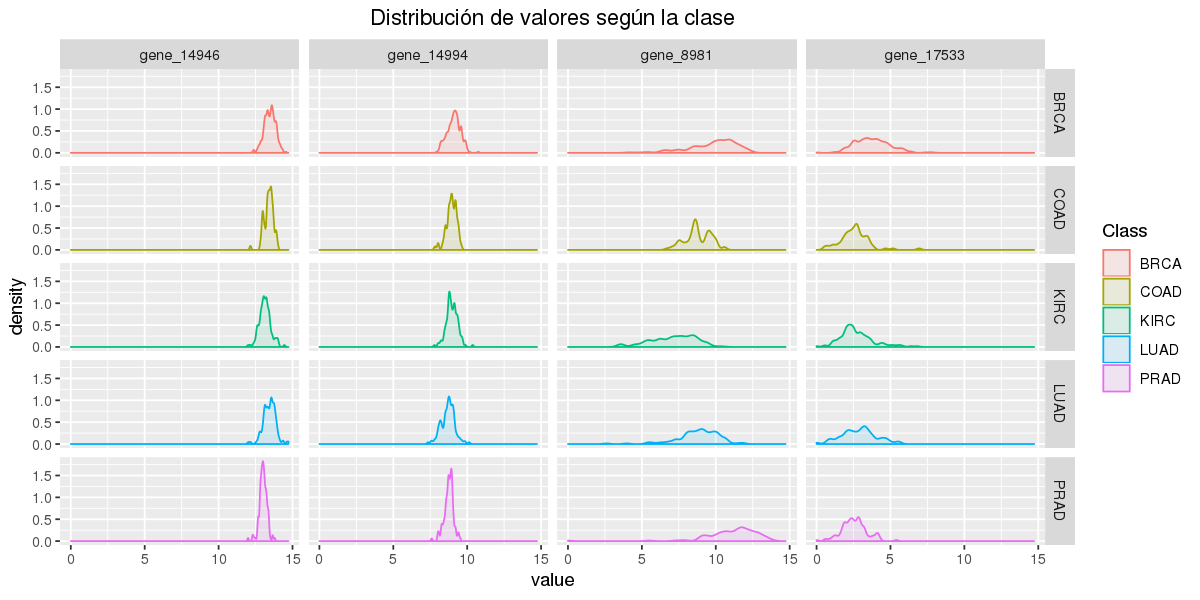

In [4]:
# Tamaño de las gráficas.
options(repr.plot.width=10, repr.plot.height=5)

ggplot(melt(tcga.filtered[(length(tcga.filtered) - 4):length(tcga.filtered)]), aes(x=value,color=Class, fill = Class)) +
    geom_density(adjust = 1/2, alpha=0.1) +
    ggtitle("Distribución de valores según la clase") +
    theme(plot.title = element_text(hjust = 0.5)) + facet_grid(rows = Class~variable)

En la gráfica anterior vemos los valores de las variables de forma individuales, lo que nos puede dar una idea inicial del tipo de probelma que es y que modelo se ajustaría mejor, sin embargo lo que nos interesará será ver como se relacionan las variables entre ellas, ya que un modelo predictivo intenta combinar las variables y sus interacciones.

Para ello vamos a ver la relación entre la información de expresión de los 2 últimos genes y el tipo de cáncer al que pertenencen.

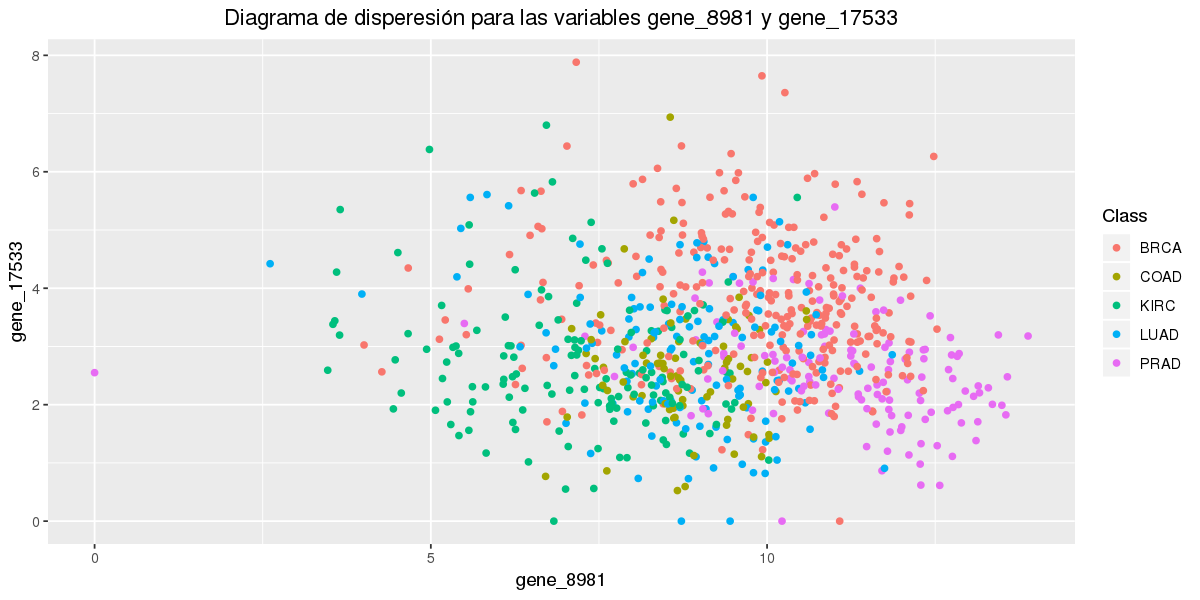

In [5]:
ggplot(tcga.filtered, aes(x=gene_8981,y=gene_17533,color=Class)) + 
    geom_point() + 
    ggtitle("Diagrama de disperesión para las variables gene_8981 y gene_17533") +
    theme(plot.title = element_text(hjust = 0.5))

Podríamos realizar la gráfica anterior 16 veces (1 para cada par de genes), sin embargo para verlo todo en un mismo bloque emplearemos una variante de la función makePairs vista en práctica

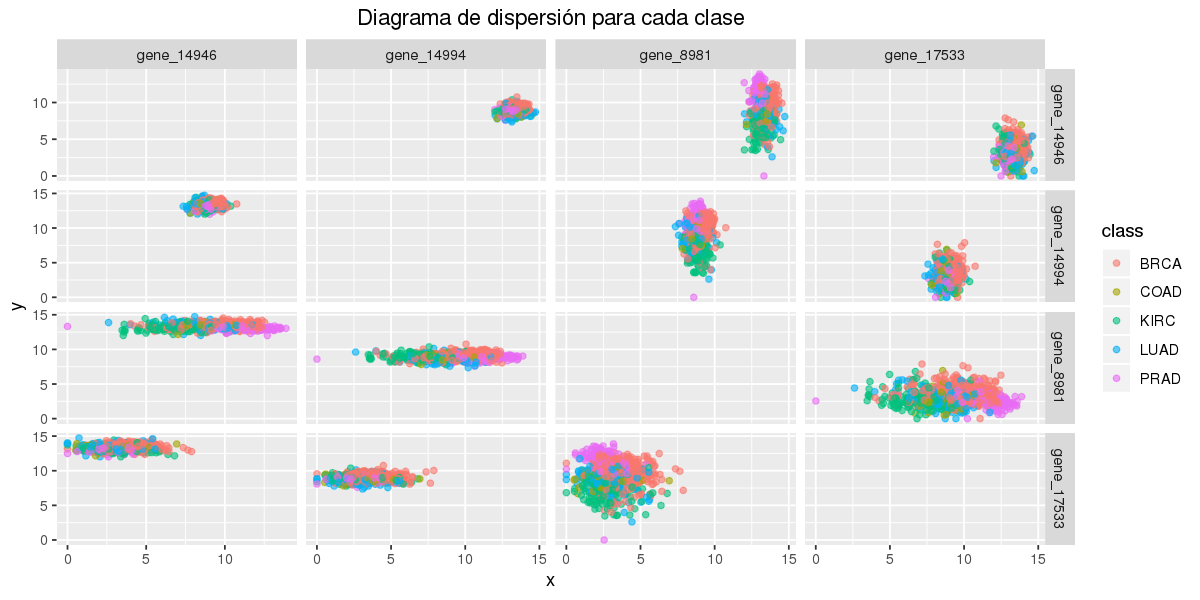

In [6]:
makePairs <- function(data,classIndex) { 
    dfm <- NULL
    for(i in 1:ncol(data)){
        if(i==classIndex)
          next
        for(j in 1:ncol(data)){ 
            if(j==classIndex)
                next
            if(i==j)
                next
            dfm <- rbind(dfm,data.frame(x=data[,i], y=data[,j], 
                                        Var1=colnames(data)[i], 
                                        Var2=colnames(data)[j],
                                        class=data[,classIndex]))
        }
    }
    dfm$Var2 <- relevel(dfm$Var2,levels(dfm$Var1)[1])
    dfm 
}
            
dataToPlot <- makePairs(tcga.filtered[(length(tcga.filtered) - 4):length(tcga.filtered)], 5)
ggplot(dataToPlot, aes_string(x = "x", y = "y")) + 
            facet_grid(Var1 ~ Var2, scales = "free") + 
            geom_point(aes(colour=class), alpha=0.6) + 
            ggtitle("Diagrama de dispersión para cada clase") +
            theme(plot.title = element_text(hjust = 0.5))

Evidentemente las conclusiones están limitadas por que sólo vemos relaciones en dos dimensiones, pero aún con esta limitación realizar esta tarea es importante para entender peculiaridades de los datos, detectar posibles problemas y contrastar lo que hemos podido inferir con lo que un modelo dice.

Una vez hemos entendido los datos sobre los que vamos a trabajar tenemos que realizar 2 particiones, una con la que entrenaremos nuestros modelos y otra con la que los validaremos. En este caso yaque tenemos 801 instancias y sólo 100 variables escogeremos un 75% de los datos para entrenamiento y un 25% para la validación.

In [7]:
inTrain <- createDataPartition(
    # indicamos la clase
    y = tcga.filtered$Class,
    
    # el porcentaje de instancias para entrenamiento
    p = .75,
    
    # controla el formato de salida
    list = FALSE
)

# Definimos nuestras particiones de entrenamiento y validación.
training <- tcga.filtered[ inTrain,]
testing <- tcga.filtered[-inTrain,]

## Esquemas de validación

Conocemos que existen distintos tipos de validación, cada uno con sus ventajas y desventajas. Sin embargo despues de probar con los diferentes esquemas para cada modelo se obtuvo que los siguientes son los que obtienen mejores resultados y por tanto serán los empleados para controlar la construcción de los modelos.

In [8]:
# Esquema de validación para árboles.
ctrlTrees <- trainControl(method="cv")

# Esquema de validación para vecinos más cercanos.
ctrlKnn <- trainControl(method="cv")

# Esquema de validación para redes neuronales. Bootstrap 10 reps.
ctrlNn <- trainControl(method = "boot632", number = 10)

# Esquema de validación para máquinas de vector soporte.
ctrlMvs <- trainControl(method="cv")

# Esquema de validación para máquinas de vector soporte.
ctrlMvsProbs <- trainControl(method="cv", classProbs = T)

## Árbol de decisión

De acuerdo con wikipedia, un árbol de decisión es un mecanismo en el que dado un conjunto de datos se fabrican diagramas de construcciones lógicas, muy similares a los sistemas de predicción basados en reglas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva, para la resolución de un problema. Por lo tanto, y teniendo en cuenta nuestros datos, parece un modelo que nos dará unos buenos resultados, sin embargo, vamos a contrastar esta hipótesis.

Tanto en teroría como en prácticas vimos distintos modelos de árboles de decisión, a continuación implementaremos los modelos J48, rpart y rpart2 para comparar su precisión para el problema dado.

In [9]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con J48.
c4.5Fit <- train(
    Class ~ .,
    data = training,
    method = "J48",
    trControl = ctrlTrees,
    # Empleamos C=0.04 y M=2 ya que son los valores que tras explorar
    # nos han dado mejor resultado y realizar siempre la exploración
    # de valores es demasiado lenta.
    tuneGrid = data.frame(C=0.04, M=2)
)

# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart.
rpartFit <- train(
    Class ~ .,
    data = training,
    method = "rpart",
    trControl = ctrlTrees,
    # Exploramos los resultados para 200 valores de cp crecientes desde 0.0.
    tuneLength = 200
)

# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
rpart2Fit <- train(
    Class ~ .,
    data = training,
    method = "rpart2",
    trControl = ctrlTrees,
    # Exploramos los resultados hasta una profundidad de 8, que es la
    # profundidad máxima del arbol.
    tuneLength = 8
)

Para comparar los modelos de manera inicial emplearemos el sistema de matriz de confusión.

In [10]:
# Datos del modelo rpart2 y matriz de confusión para los datos de validación
c4.5Fit$results[rownames(c4.5Fit$bestTune),1:4]
confusionMatrix(predict(c4.5Fit,testing), factor(testing$Class))$overall[1:4]

# Datos del modelo rpart2 y matriz de confusión para los datos de validación
rpartFit$results[rownames(rpartFit$bestTune),1:4]
confusionMatrix(predict(rpartFit,testing), factor(testing$Class))$overall[1:4]

# Datos del modelo rpart2 y matriz de confusión para los datos de validación
rpart2Fit$results[rownames(rpart2Fit$bestTune),1:4]
confusionMatrix(predict(rpart2Fit,testing), factor(testing$Class))$overall[1:4]

C,M,Accuracy,Kappa
0.04,2,0.8417629,0.7893901


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9045226     0.8739835     0.8549181     0.9415330

,cp,Accuracy,Kappa,AccuracySD
12,0.01326926,0.8619992,0.8164838,0.03839539


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8542714     0.8069964     0.7974599     0.9001806

,maxdepth,Accuracy,Kappa,AccuracySD
5,8,0.8619992,0.8164838,0.03839539


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8542714     0.8069964     0.7974599     0.9001806

De los modelos datos anteriores podemos extraer direfentes conclusiones preliminares. Por ejemplo, tanto rpart como rpart2 obtiene una precisión mayor sobre los datos de entrenamiento que j48, sin embargo cuando realizamos la validación externa se puede observar que es precisamente j48 el que obtiene un resultado muy superior a rpart y rpart2. Por lo tanto como modelo de árbol de decisión escogeremos el j48, que nos ofrece un 90.45% de precisión en los datos de validación.

## Vecinos más cercanos

In [11]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
knnFit <- train(
  Class ~ .,
  data = training,
  method = "knn",
  trControl = ctrlKnn,
  tuneLength = 6
)

In [12]:
knnFit$results[rownames(knnFit$bestTune),1:4]
confusionMatrix(predict(knnFit,testing), factor(testing$Class))$overall[1:4]

k,Accuracy,Kappa,AccuracySD
5,0.9652056,0.9537264,0.0261985


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9698492     0.9602503     0.9355328     0.9888564

## Redes neuronales

Este es un método de clasificación no paramétrico, que estima el valor de la función de densidad de probabilidad o directamente la probabilidad a posteriori de que un elemento x pertenezca a la clase C a partir de la información proporcionada por el conjunto de prototipos. En el proceso de aprendizaje no se hace ninguna suposición acerca de la distribución de las variables predictoras.

Ahora pasamos a crear un primer modelo de red neuronal con una sola capa oculta. Para determinar el número de unidades ocultas pedimos a la función train que pruebe varios valores de 1 hasta 10.

In [13]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit <- train(
    Class ~ .,
    data = training,
    method = "mlp",
    trControl = ctrlNn,
    tuneGrid = data.frame(size=seq(1,50,1))
)

Si exploramos los resultados arrojados por el entrenamiento del modelo anterior podemos observar los siguientes resultados:

In [14]:
# Modelo de una única capa oculta.
nn1LFit$results[rownames(nn1LFit$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta.
confusionMatrix(predict(nn1LFit,testing), factor(testing$Class))$overall[1:4]

,size,Accuracy,Kappa,AccuracySD
26,26,0.3725298,0.00120366,0.01585879


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.3768844     0.0000000     0.3093354     0.4481606

Para el modelo anterior encontramos la precisión más elevada se da cuando empleamos 2 neuronas en la capa oculta, con un 37.19% sobre los datos de entrenamiento y un 37.68% sobre los datos de validación.

Vamos a probar con redes más profundas, pero limitando la complejidad (número de parámetros) a un nivel similar a la red anterior. Por lo tanto exploraremos también modelos de 2 y 3 capas ocultas.

In [15]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn2LFit <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrlNn,
    learnFuncParams = c(0.03,0),
    tuneGrid = expand.grid(layer1=seq(25,27,1), layer2=seq(25,27,1), layer3=0)
)

Si exploramos los resultados arrojados por el entrenamiento del modelo anterior podemos observar los siguientes resultados:

In [16]:
# Modelo de 2 capas ocultas.
nn2LFit$results[rownames(nn2LFit$bestTune),1:4]

# Matriz de confusión para el modelo de dos capas ocultas.
confusionMatrix(predict(nn2LFit,testing), factor(testing$Class))$overall[1:4]

,layer1,layer2,layer3,Accuracy
7,27,25,0,0.8393947


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9246231     0.9004735     0.8787246     0.9572001

Y por últmo realizaremos un modelo con 3 capas ocultas.

In [17]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn3LFit <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrlNn,
    learnFuncParams = c(0.03,0),
    tuneGrid = expand.grid(layer1=seq(25,27,1), layer2=seq(25,27,1), layer3=seq(25,27,1))
)

Si exploramos los resultados arrojados por el entrenamiento del modelo anterior podemos observar los siguientes resultados:

In [18]:
# Modelo de tres capas ocultas.
nn3LFit$results[rownames(nn3LFit$bestTune),1:4]

# Matriz de confusión para el modelo de tres capas ocultas.
confusionMatrix(predict(nn3LFit,testing), factor(testing$Class))$overall[1:4]

,layer1,layer2,layer3,Accuracy
24,27,26,27,0.7333865


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8643216     0.8154306     0.8087658     0.9086460

Para intentar entender estas diferencias vamos a inspeccionar como ha ido el proceso de aprendizaje de cada modelo.

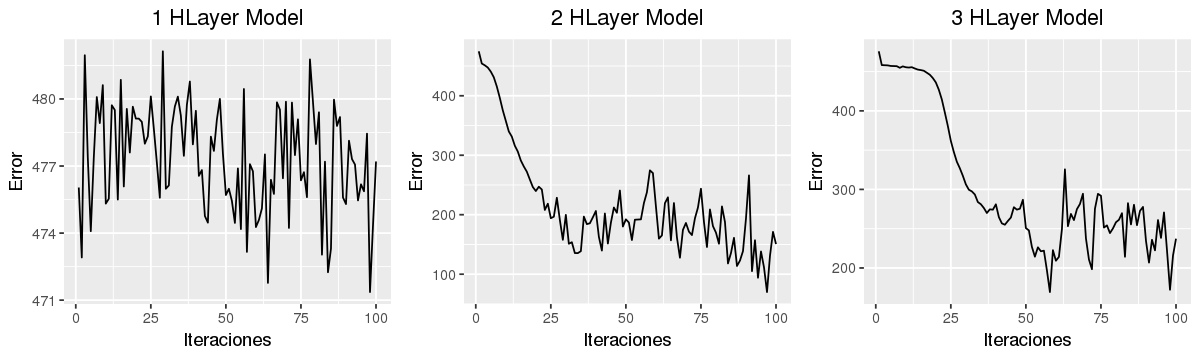

In [19]:
# Configuración del tamaño de las gráficas.
options(repr.plot.width=10, repr.plot.height=3)

errorNn1Err <- ggplot() + geom_line(aes(x=1:length(nn1LFit$finalModel$IterativeFitError), y=nn1LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("1 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn2Err <- ggplot() + geom_line(aes(x=1:length(nn2LFit$finalModel$IterativeFitError), y=nn2LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("2 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn3Err <- ggplot() + geom_line(aes(x=1:length(nn3LFit$finalModel$IterativeFitError), y=nn3LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("3 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

grid.arrange(errorNn1Err, errorNn2Err, errorNn3Err, ncol=3)

Bien, pues ahora vamos a generar un modelo fijando el número de neuronas que daba el mejor resultado, pero aumentando el número de iteraciones. Previamente se ha comprovado que para valores mayores de 500 el error permanece más o menos constante en todos los modelos, por tanto el valor `maxit` se corresponderá con el que mejor resultado de para los datos de validación. Así mismo también fijaremos el ratio de aprendizaje en 0.03 ya que es el que mejores resultados nos da.

In [20]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn1LFitOptimized <- train(
    Class ~ .,
    data = training,
    method = "mlp",
    trControl = ctrlNn,
    tuneGrid = data.frame(size=26),
    maxit = 1000,
    learnFuncParams = c(0.03,0)
)

In [21]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn2LFitOptimized <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrlNn,
    tuneGrid = expand.grid(layer1=27, layer2=25, layer3=0),
    maxit = 1000,
    learnFuncParams = c(0.03,0)
)

In [22]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

# Realizamos el entrenamiento de nuestro modelo
nn3LFitOptimized <- train(
    Class ~ .,
    data = training,
    method = "mlpML",
    trControl = ctrlNn,
    tuneGrid = expand.grid(layer1=27, layer2=26, layer3=27),
    maxit = 1750,
    learnFuncParams = c(0.03,0)
)

Exploramos los resultados obtenidos por el entrenamiento de los modelos anteriores.

In [23]:
# Modelo de una única capa oculta.
nn1LFitOptimized$results[rownames(nn1LFitOptimized$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta.
confusionMatrix(predict(nn1LFitOptimized,testing), factor(testing$Class))$overall[1:4]

# Modelo de 2 capas oculta con 5-7 neuronas.
nn2LFitOptimized$results[rownames(nn2LFitOptimized$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta y 7 neuronas.
confusionMatrix(predict(nn2LFitOptimized,testing), factor(testing$Class))$overall[1:4]

# Modelo de tres capas ocultas con 5-5-5 neuronas.
nn3LFitOptimized$results[rownames(nn3LFitOptimized$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta y 7 neuronas.
confusionMatrix(predict(nn3LFitOptimized,testing), factor(testing$Class))$overall[1:4]

size,Accuracy,Kappa,AccuracySD
26,0.982324,0.9767535,0.01659418


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9798995     0.9734605     0.9493370     0.9944968

layer1,layer2,layer3,Accuracy
27,25,0,0.9010665


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9447236     0.9275549     0.9032493     0.9720866

layer1,layer2,layer3,Accuracy
27,26,27,0.5878507


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8442211     0.7931046     0.7862307     0.8916355

Como podemos ver, ahora los modelos de 1 y 2 capas ocultas obtienen los mejores resultados, llegando a una precisión del 97.99% y 94.47% respectivamente. Veamos las curvas de aprendizaje de cada modelo, en ellas podremos ver que detenemos las iteraciones cuando el error cometido es mínimo.

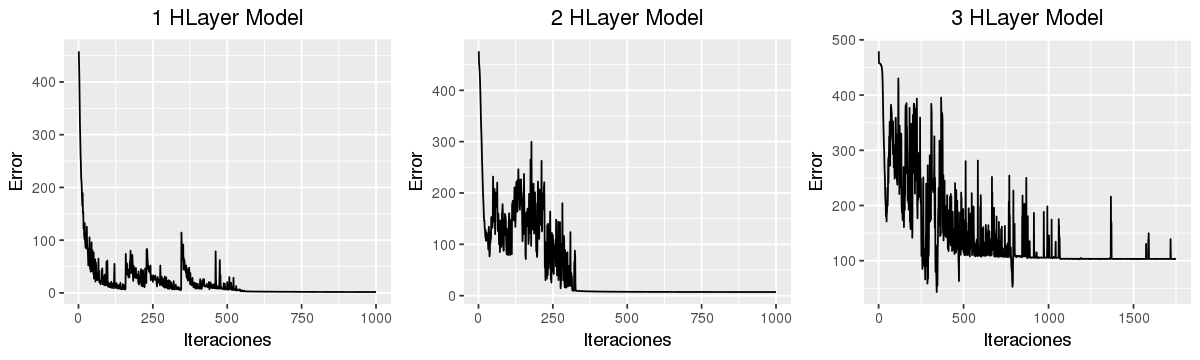

In [24]:
errorNn1OptimizedErr <- ggplot() + geom_line(aes(x=1:length(nn1LFitOptimized$finalModel$IterativeFitError), y=nn1LFitOptimized$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("1 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn2OptimizedErr <- ggplot() + geom_line(aes(x=1:length(nn2LFitOptimized$finalModel$IterativeFitError), y=nn2LFitOptimized$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("2 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn3OptimizedErr <- ggplot() + geom_line(aes(x=1:length(nn3LFitOptimized$finalModel$IterativeFitError), y=nn3LFitOptimized$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("3 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

grid.arrange(errorNn1OptimizedErr, errorNn2OptimizedErr, errorNn3OptimizedErr, ncol=3)

## Máquinas vector soporte

Estos métodos están propiamente relacionados con problemas de clasificación y regresión. Dado un conjunto de ejemplos de entrenamiento (de muestras) podemos etiquetar las clases y entrenar una SVM para construir un modelo que prediga la clase de una nueva muestra. Intuitivamente, una SVM es un modelo que representa a los puntos de muestra en el espacio, separando las clases a 2 espacios lo más amplios posibles mediante un hiperplano de separación definido como el vector entre los 2 puntos, de las 2 clases, más cercanos al que se llama vector soporte. Cuando las nuevas muestras se ponen en correspondencia con dicho modelo, en función de los espacios a los que pertenezcan, pueden ser clasificadas a una o la otra clase.

De la misma forma que con los árboles de decisión para las máquinas de vector soporte encontramos diferentes tipos, Lineares, Polinomial y Radial

In [25]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

svmLinealFit <- train(
    Class ~ .,
    data = training,
    method = "svmLinear",
    trControl = ctrlMvs,
    tuneGrid = data.frame(C=1),
    scale = FALSE
)

In [26]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

svmPolyFit <- train(
    Class ~ .,
    data = training,
    method = "svmPoly",
    trControl = ctrlMvsProbs,
    tuneGrid = expand.grid(degree=c(2,3),C=c(1,5),scale = c(0.1, 0.5, 1))
)

In [27]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(236856)

svmRadialFit <- train(
    Class ~ .,
    data = training,
    method = "svmRadial",
    trControl = ctrlMvsProbs, 
    tuneGrid = expand.grid(sigma=c(1,3),C=c(1,5)) 
)

maximum number of iterations reached -1.727435e-05 -1.268396e-05maximum number of iterations reached -1.727435e-05 -1.268396e-05

In [28]:
svmLinealFit$results[rownames(svmLinealFit$bestTune),1:4]
svmPolyFit$results[rownames(svmPolyFit$bestTune),1:5]
svmRadialFit$results[rownames(svmRadialFit$bestTune),1:4]

confusionMatrix(predict(svmLinealFit,testing),factor(testing$Class))$overall[1:2]
confusionMatrix(predict(svmPolyFit,testing),factor(testing$Class))$overall[1:2]
confusionMatrix(predict(svmRadialFit,testing),factor(testing$Class))$overall[1:2]

C,Accuracy,Kappa,AccuracySD
1,0.9799917,0.9735754,0.01331374


,degree,C,scale,Accuracy,Kappa
4,2,5,0.1,0.8238621,0.7595217


,sigma,C,Accuracy,Kappa
3,3,1,0.3737775,0


Accuracy     Kappa 
0.9698492 0.9602119

Accuracy     Kappa 
0.8291457 0.7679380

Accuracy     Kappa 
0.3768844 0.0000000

## Comparación de los paradigmas

Nos encontramos ante un problema que precisa de; dados unos valores para unos genes, predecir el tipo de cáncer. Por lo tanto es un problema de clasificación.

A continuación se muestra una gráfica con los valores de precisión obtenidos para cada paradigma

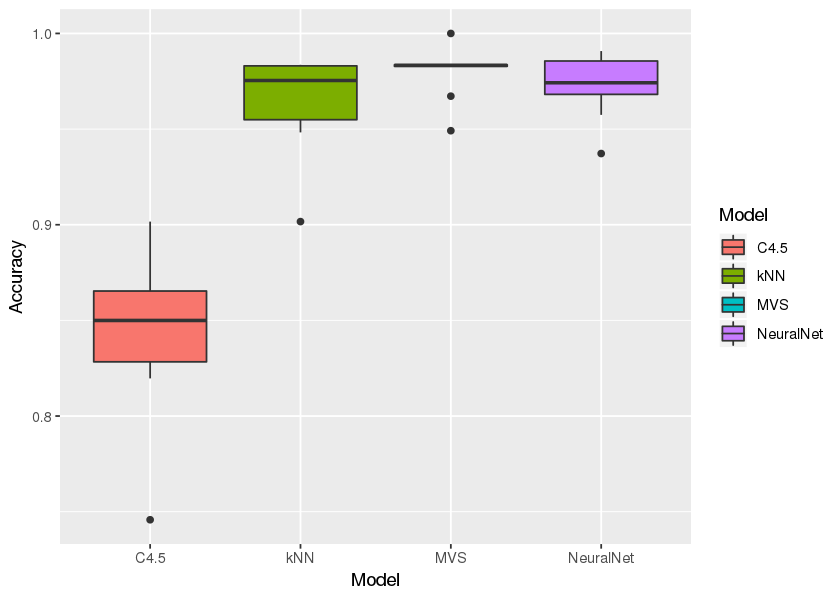

In [29]:
options(repr.plot.width=7, repr.plot.height=5)
dfm.resamp <- data.frame(Accuracy = c(nn1LFitOptimized$resample$Accuracy,
                                      c4.5Fit$resample$Accuracy,
                                      knnFit$resample$Accuracy,
                                      svmLinealFit$resample$Accuracy), 
                        Model = rep(c('NeuralNet','C4.5','kNN', 'MVS'), each=10))
ggplot(dfm.resamp,aes(x=Model, y=Accuracy, fill=Model)) + geom_boxplot()

Se puede observar que para este problema claramente el mejor paradigma es el de máquinas vector soporte que obtiene una precisión muy cercana a 1, seguida de vecinos más cercanos, que pese a tener una precisión un poco inferior presenta más estabilidad. 